In [70]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE

In [71]:
abt = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv")
abt.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Model Training

splitting dataframe into separate objects

y for target variables

x for input features



In [72]:
import pandas as pd

abt = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv")

y = abt.Exited

X = abt.drop(['Exited'], axis=1)

print(X.shape, y.shape)

(10000, 10) (10000,)


In [73]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [74]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [75]:
import numpy as np
import pandas as pd
from collections import Counter

def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [76]:
from collections import Counter
class_count(y)

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


# Split The Data

Splitting our data into separate training and test sets

training set(70%): to teach the model

testing set(30%): to evaluate performance


In [77]:
from sklearn.model_selection import train_test_split

random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


# Preprocessing pipeline

Scale numerical data and encode categorical data

MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [79]:
num_features = []

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 3, 4, 5, 6, 7, 8, 9]


In [80]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[1, 2]


In [81]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

# Define column transformer
# Need to be numeric not string to specify columns name
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse_output=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False), [1, 2])])

In [82]:
# Import classifier
from sklearn import tree
from imblearn.pipeline import make_pipeline as imbl_pipe
from imblearn.over_sampling import SMOTE

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  tree.DecisionTreeClassifier(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=10))])

In [83]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
rf_param_grid = {
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10, 15],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4]
}
rf_grid = GridSearchCV(model, rf_param_grid, verbose=3, cv=5, scoring='accuracy')

In [84]:
X_train = X_train.values
X_test = X_test.values

In [85]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2;, score=0.783 total time=   0.1s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2;, score=0.766 total time=   0.1s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2;, score=0.761 total time=   0.1s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2;, score=0.769 total time=   0.1s
[CV 5/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [1,
                                                                          2])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=10))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'decisiontreeclassifier__min_samples_leaf': [1, 5, 10,
                                                                      15],
                         'decisiontreeclassifier__min_samples_split': [2, 3,
                                                                       4]},
             scoring='accuracy', verbose=3)

In [86]:
print(rf_grid.best_params_)

{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_leaf': 15, 'decisiontreeclassifier__min_samples_split': 2}


In [87]:
print(rf_grid.best_score_)

0.8047142857142857


In [88]:
print(f"Training Data Score: {rf_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_grid.score(X_test, y_test)}")

Training Data Score: 0.8655714285714285
Testing Data Score: 0.7956666666666666


In [89]:
predictions = rf_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 0 0 1 1 1 0 0 0 0]
First 10 Actual labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [90]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,1
1,0,0
2,0,0
3,1,0
4,1,0
...,...,...
2995,0,0
2996,0,0
2997,0,0
2998,0,0


In [91]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
print(cm)

[[2016  373]
 [ 240  371]]


In [92]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.84 0.16]
 [0.39 0.61]]


In [93]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87      2389
           1       0.50      0.61      0.55       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.81      0.80      0.80      3000



In [94]:
pred = rf_grid.predict(X_test[:1])

In [95]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [1]


In [96]:
rf_model = joblib.load(full_path)
print(rf_model.score(X_test, y_test))

0.7956666666666666


# Visualization

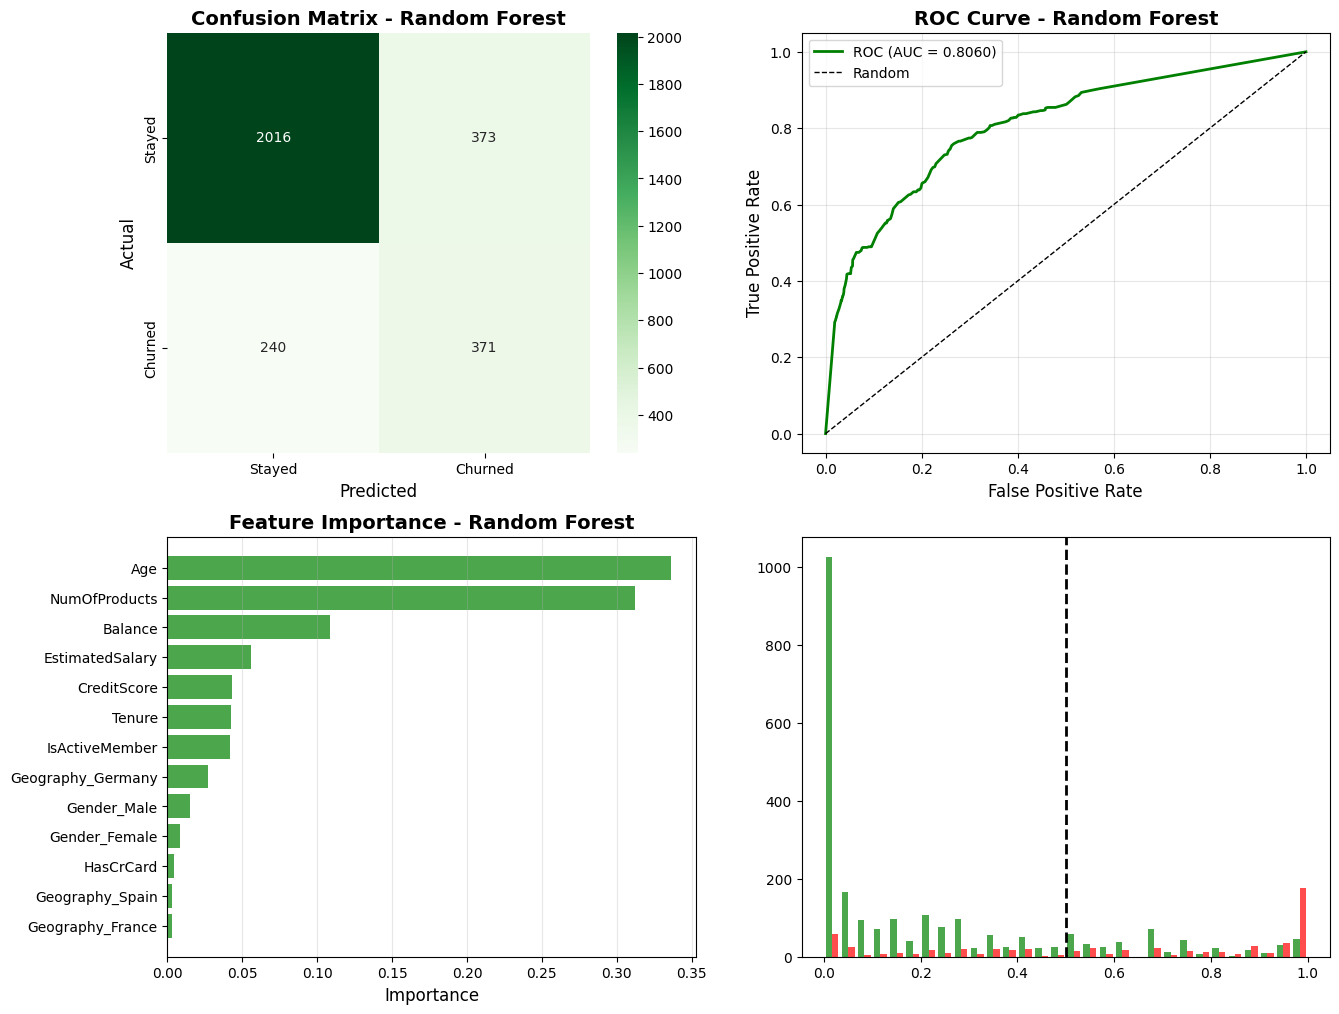

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# y_pred is already calculated as 'predictions'
y_pred = predictions

# Calculate y_pred_proba
y_pred_proba = rf_grid.predict_proba(X_test)[:, 1]

# Calculate roc_auc
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Get the best estimator from GridSearchCV
best_model = rf_grid.best_estimator_.named_steps['decisiontreeclassifier']

# Get the preprocessor from the pipeline
preprocessor = rf_grid.best_estimator_.named_steps['columntransformer']

# Get feature names after preprocessing
# Numerical features
scaled_features = num_columns

# Categorical features after one-hot encoding
onehot_encoder = preprocessor.named_transformers_['onehotencoder']
encoded_feature_names = onehot_encoder.get_feature_names_out(cat_columns)

# Combine all feature names
X_encoded_columns = list(scaled_features) + list(encoded_feature_names)


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0, 0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
axes[0, 0].set_title('Confusion Matrix - Random Forest',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12)
axes[0, 0].set_xlabel('Predicted', fontsize=12)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.4f})', color='green')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_encoded_columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

axes[1, 0].barh(range(len(feature_importance)), feature_importance['Importance'], color='green', alpha=0.7)
axes[1, 0].set_yticks(range(len(feature_importance)))
axes[1, 0].set_yticklabels(feature_importance['Feature'])
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# Prediction Distribution
axes[1, 1].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
                bins=30, label=['Stayed', 'Churned'],
                color=['green', 'red'], alpha=0.7)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)